In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pickle
import tensorflow_addons as tfa
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import DifferentiableHOS as DHOS
from itertools import cycle
from DifferentiableHOS.ks_tf import ks93_tf
from DifferentiableHOS.NLA_IA import  Epsilon2,Epsilon1,tidal_field,interpolation
from DifferentiableHOS.fourier_smoothing import fourier_smoothing

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.cosmology import Planck15
import astropy.units as u
from flowpm import tfpm
from flowpm.utils import cic_paint, compensate_cic
from flowpm.tfpower import linear_matter_power
from functools import partial

In [3]:
# Loads PGD parameters
with open('/global/u1/d/dlan/DifferentiableHOS/notebooks/results_fit_PGD_205_128.pkl', "rb") as f:
    pgd_data = pickle.load(f)
    pgdparams = pgd_data['params']

In [4]:
# Below are a few parameters
n_lens = 11       # Number of lensplanes in the lightcone
box_size = 205.   # Transverse comoving size of the simulation volume
nc = 128          # Number of transverse voxels in the simulation volume
field_size = 5    # Size of the lensing field in degrees
field_npix = 1024 # Number of pixels in the lensing field 
batch_size = 1    # Number of simulations to run in parallel
z_source = np.array([0.9720714]) # We'll be using a single redshift for now

In [5]:
# Instantiates a cosmology with desired parameters
cosmology = flowpm.cosmology.Planck15()
# Schedule the center of the lensplanes we want for ray tracing
r = tf.linspace(0., box_size*n_lens, n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])
# Retrieve the scale factor corresponding to these distances
a = flowpm.tfbackground.a_of_chi(cosmology, r)
a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)
# We run 4 steps from initial scale factor to start of raytracing
init_stages = tf.linspace(0.1, a[-1], 4)
# Then one step per lens plane
stages = tf.concat([init_stages, a_center.numpy()[::-1]], axis=0)

In [6]:

#Create some initial conditions
initial_conditions = flowpm.linear_field([nc, nc, nc],
                                         [box_size, box_size, box_size], 
                                         lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
                                         batch_size=batch_size)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [7]:
# Run the Nbody
states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True,
                      pgdparams=pgdparams) 

In [8]:
%%time
# Extract the lensplanes
lensplanes = []
matrix = flowpm.raytracing.rotation_matrices()
for i, j in zip(range(len(a_center)), cycle(range(6))):
    plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2,
                                            width=nc,
                                            plane_resolution=2048,
                                            rotation=matrix[j],
                                            shift=flowpm.raytracing.random_2d_shift())
    plane = fourier_smoothing(plane,sigma=1.024,resolution=2048)
    lensplanes.append((r_center[i], states[::-1][i][0], plane))

CPU times: user 50.1 s, sys: 29.5 s, total: 1min 19s
Wall time: 36.2 s


In [9]:
%%time
# Get convergence map
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

m = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes, 
                    dx=box_size/2048, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source)
m= tf.reshape(m, [batch_size, field_npix,field_npix])

CPU times: user 5.9 s, sys: 2.01 s, total: 7.91 s
Wall time: 2.22 s


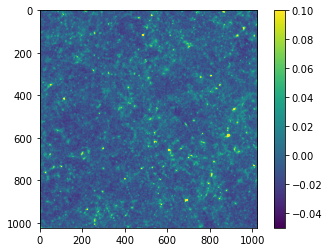

In [10]:
imshow(m[0],vmax=0.1, vmin=-0.05)
colorbar()

In [11]:
pix_scale = field_size/field_npix*60              # arcmin
sigma_pix=1/pix_scale


In [12]:
ngal = 10                          # gal/arcmin **2
ngal_per_pix = ngal * pix_scale**2 # galaxies per pixels (I think)
sigma_e = 0.26 / sqrt(2 * ngal_per_pix) # Rescaled noise sigma

In [13]:
knFPM = m[0]+ sigma_e * randn(1024,1024), 5*u.deg

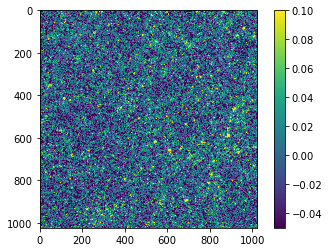

In [14]:
imshow(knFPM[0],vmax=0.1, vmin=-0.05)
colorbar()

In [15]:
tidial_plane_resolution=2048
tidial_field_npix=1024 #we need the same resolution of the convergence map

In [16]:

lens_source=states[::-1][11][1]
  


In [17]:
plane_source = flowpm.raytracing.density_plane(lens_source,
                                            [nc, nc, nc],
                                            nc//2,
                                            width=nc,
                                            plane_resolution=tidial_plane_resolution,
                                            )

We are using a two-dimensional Gaussian filter with σG = 0.1Mpc/h according to https://arxiv.org/pdf/2107.08041.pdf

In [18]:
sigma=0.1 #Mpc/h
pix_scale_source = box_size/tidial_field_npix      #Mpc       
sigma_pix_source=sigma/pix_scale_source

In [19]:
tidal_planes=tidal_field(plane_source,tidial_plane_resolution,pix_scale_source)

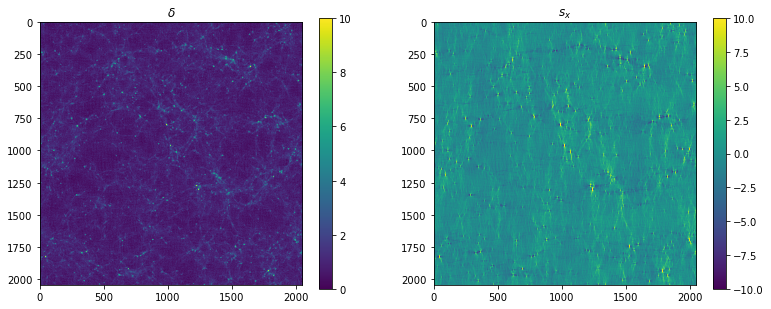

In [20]:
figure(figsize=[20,10])
subplot(131)
imshow(plane_source[0],vmin=0,vmax=10)
title('$\delta$')
colorbar(shrink=0.5)
subplot(132)
imshow(tidal_planes[0],vmin=-10,vmax=10)
title('$s_x$')
colorbar(shrink=0.5)



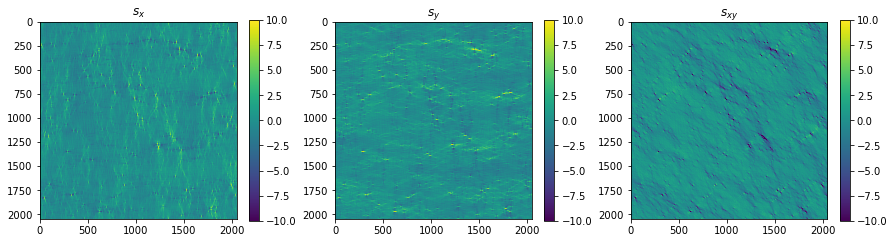

In [21]:
figure(figsize=[15,5])
subplot(131)
imshow(tidal_planes[0],vmin=-10,vmax=10)
title('$s_x$')
colorbar(shrink=0.74)
subplot(132)
imshow(tidal_planes[1],vmin=-10,vmax=10)
title('$s_y$')
colorbar(shrink=0.74)
subplot(133)
imshow(tidal_planes[2],vmin=-10,vmax=10)
title('$s_{xy}$');
colorbar(shrink=0.74)

In [22]:
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size,tidial_field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size,tidial_field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

In [23]:
im=interpolation(tidal_planes,dx=box_size/tidial_field_npix,r_source=2255.,tidial_field_npix=tidial_field_npix,coords=c)

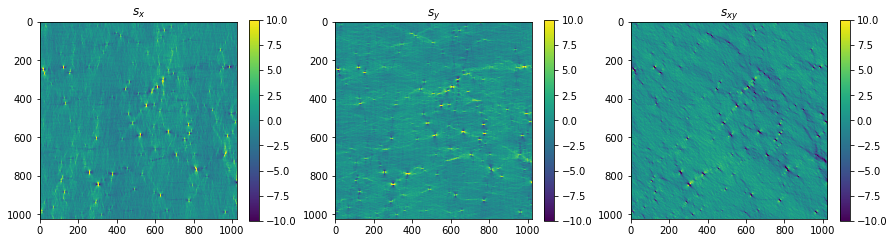

In [24]:
figure(figsize=[15,5])
subplot(131)
imshow(im[0],vmin=-10,vmax=10)
title('$s_x$')
colorbar(shrink=0.74)
subplot(132)
imshow(im[1],vmin=-10,vmax=10)
title('$s_y$')
colorbar(shrink=0.74)
subplot(133)
imshow(im[2],vmin=-10,vmax=10)
title('$s_{xy}$');
colorbar(shrink=0.74)

In [25]:
A1=1 #1.5,2
C1=5e-14

In [26]:
e1=Epsilon1(cosmology,z_source,im,A1,C1)
e2=Epsilon1(cosmology,z_source,im,A1,C1)

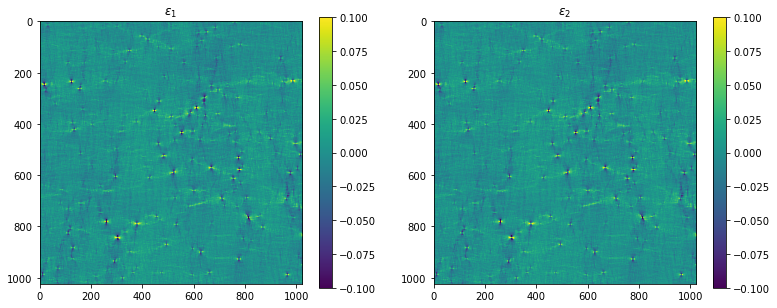

In [27]:
figure(figsize=[20,10])
subplot(131)
imshow(e1,vmin=-0.1,vmax=0.1)
title('$\epsilon_1$')
colorbar(shrink=0.50)
subplot(132)
imshow(e2,vmin=-0.1,vmax=0.1)
title('$\epsilon_2$')
colorbar(shrink=0.50)


In [28]:
ke_tf,kb_tf=ks93_tf(e1, e2)

In [29]:
m_IA=m[0]+ke_tf

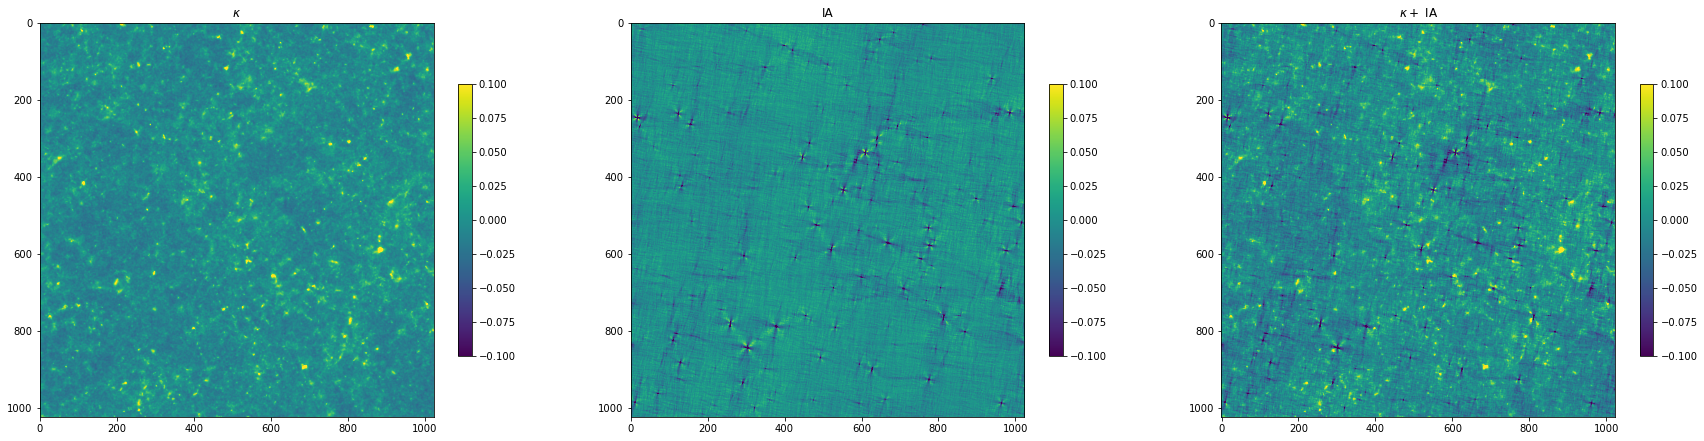

In [30]:
figure(figsize=[30,10])
subplot(131)
imshow(m[0],vmin=-0.1,vmax=0.1)
title('$\kappa$')
colorbar(shrink=0.50)
subplot(132)
imshow(ke_tf,vmin=-0.1,vmax=0.1)
title('IA')
colorbar(shrink=0.50)
subplot(133)
imshow(m_IA,vmin=-0.1,vmax=0.1)
title('$\kappa+$ IA')
colorbar(shrink=0.50)

Quick test to see if Tf implementation of Kaiser & Squires (1993) gives the some results of the one in numpy

In [31]:
import jax
def ks93(g1, g2):
    """Direct inversion of weak-lensing shear to convergence.
    This function is an implementation of the Kaiser & Squires (1993) mass
    mapping algorithm. Due to the mass sheet degeneracy, the convergence is
    recovered only up to an overall additive constant. It is chosen here to
    produce output maps of mean zero. The inversion is performed in Fourier
    space for speed.
    Parameters
    ----------
    g1, g2 : array_like
        2D input arrays corresponding to the first and second (i.e., real and
        imaginary) components of shear, binned spatially to a regular grid.
    Returns
    -------
    kE, kB : tuple of numpy arrays
        E-mode and B-mode maps of convergence.
    Raises
    ------
    AssertionError
        For input arrays of different sizes.
    See Also
    --------
    bin2d
        For binning a galaxy shear catalog.
    Examples
    --------
    >>> # (g1, g2) should in practice be measurements from a real galaxy survey
    >>> g1, g2 = 0.1 * np.random.randn(2, 32, 32) + 0.1 * np.ones((2, 32, 32))
    >>> kE, kB = ks93(g1, g2)
    >>> kE.shape
    (32, 32)
    >>> kE.mean()
    1.0842021724855044e-18
    """
    # Check consistency of input maps
    assert g1.shape == g2.shape

    # Compute Fourier space grids
    (nx, ny) = g1.shape
    k1, k2 = np.meshgrid(np.fft.fftfreq(ny), np.fft.fftfreq(nx))

    # Compute Fourier transforms of g1 and g2
    g1hat = np.fft.fft2(g1)
    g2hat = np.fft.fft2(g2)

    # Apply Fourier space inversion operator
    p1 = k1 * k1 - k2 * k2
    p2 = 2 * k1 * k2
    k2 = k1 * k1 + k2 * k2
    #k2[0, 0] = 1  # avoid division by 0
    k2 = jax.ops.index_update(k2, jax.ops.index[0, 0], 1.) # avoid division by 0
    kEhat = (p1 * g1hat + p2 * g2hat) / k2
    kBhat = -(p2 * g1hat - p1 * g2hat) / k2


    # Transform back to pixel space
    kE = np.fft.ifft2(kEhat).real
    kB = np.fft.ifft2(kBhat).real

    return kE, kB


In [32]:
ke,kb=ks93(e1, e2)

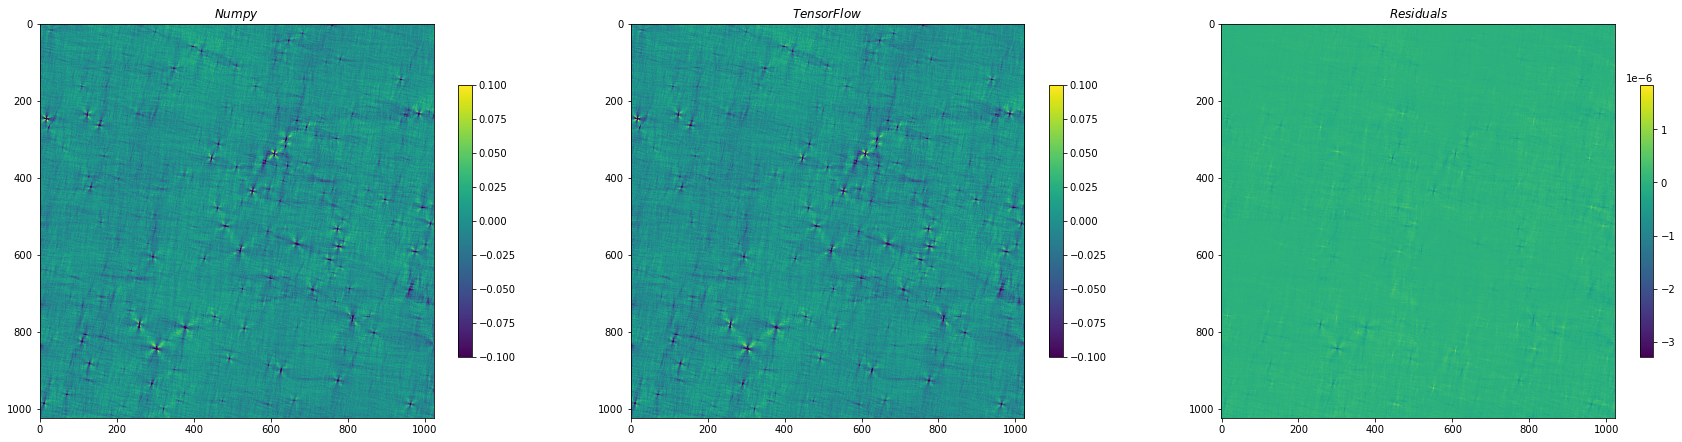

In [33]:
figure(figsize=[30,10])
subplot(131)
imshow(ke,vmin=-0.1,vmax=0.1)
title('$Numpy$')
colorbar(shrink=0.50)
subplot(132)
imshow(ke_tf,vmin=-0.1,vmax=0.1)
title('$TensorFlow$')
colorbar(shrink=0.50)
subplot(133)
imshow(ke-ke_tf)
title('$Residuals$')
colorbar(shrink=0.50)